## Accuracy=99.75% 



In [1]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Load Kaggle's 42,000 training images

In [2]:
# LOAD THE DATA
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [3]:
# PREPARE DATA FOR NEURAL NETWORK
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

X_train = X_train / 255.0
test = test / 255.0


In [4]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

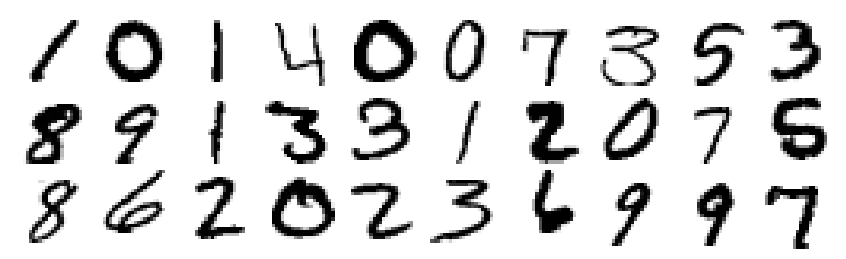

In [5]:
import matplotlib.pyplot as plt
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

## Augmentation 

Following Augmentation have been applied on this set of 42,000 images training images.

### rotation_range


### rotation_range=10,  

### zoom_range = 0.10,  


### width_shift_range=0.1


### height_shift_range

In [6]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
# datagen = ImageDataGenerator(
#         rotation_range=10,  
#         zoom_range = 0.10,  
#         width_shift_range=0.1, 
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=True,
#         brightness_range=[0.2,1.1],        
#         )

datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

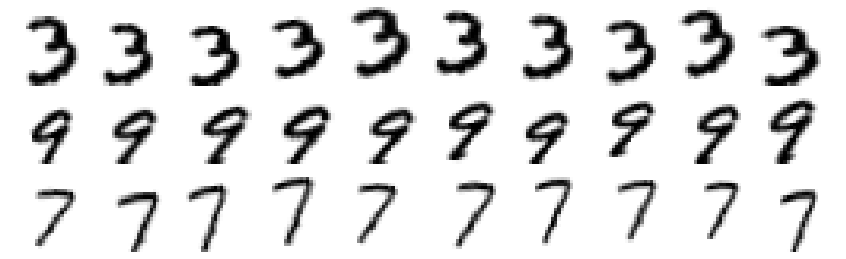

In [7]:
# PREVIEW AUGMENTED IMAGES
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# Build 15 Convolutional Neural Networks!

In [8]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

2022-04-15 10:34:29.549294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 10:34:29.660670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 10:34:29.661762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-15 10:34:29.663742: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Architectural highlights
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/LeNet5.png)

The CNNs in this kernel follow [LeNet5's][1] design (pictured above) with the following improvements:  
* Two stacked 3x3 filters replace the single 5x5 filters. These become nonlinear 5x5 convolutions
* A convolution with stride 2 replaces pooling layers. These become learnable pooling layers.
* ReLU activation replaces sigmoid.
* Batch normalization is added
* Dropout is added
* More feature maps (channels) are added
* An ensemble of 15 CNNs with bagging is used  
  
Experiments [(here)][2] show that each of these changes improve classification accuracy.

[1]:http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
[2]:https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

# Train 15 CNNs

In [9]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 45
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-15 10:34:36.256244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-15 10:34:38.592680: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


CNN 1: Epochs=45, Train accuracy=0.99663, Validation accuracy=0.99643
CNN 2: Epochs=45, Train accuracy=0.99626, Validation accuracy=0.99595
CNN 3: Epochs=45, Train accuracy=0.99626, Validation accuracy=0.99595
CNN 4: Epochs=45, Train accuracy=0.99621, Validation accuracy=0.99810
CNN 5: Epochs=45, Train accuracy=0.99624, Validation accuracy=0.99595
CNN 6: Epochs=45, Train accuracy=0.99616, Validation accuracy=0.99595
CNN 7: Epochs=45, Train accuracy=0.99629, Validation accuracy=0.99571
CNN 8: Epochs=45, Train accuracy=0.99626, Validation accuracy=0.99619
CNN 9: Epochs=45, Train accuracy=0.99629, Validation accuracy=0.99524
CNN 10: Epochs=45, Train accuracy=0.99605, Validation accuracy=0.99571
CNN 11: Epochs=45, Train accuracy=0.99629, Validation accuracy=0.99571
CNN 12: Epochs=45, Train accuracy=0.99608, Validation accuracy=0.99714
CNN 13: Epochs=45, Train accuracy=0.99632, Validation accuracy=0.99571
CNN 14: Epochs=45, Train accuracy=0.99624, Validation accuracy=0.99643
CNN 15: Epochs=

# Paul - Prev with extra augmentation

CNN 1: Epochs=45, Train accuracy=0.96044, Validation accuracy=0.21262

CNN 2: Epochs=45, Train accuracy=0.96189, Validation accuracy=0.10548

CNN 3: Epochs=45, Train accuracy=0.96073, Validation accuracy=0.11357

CNN 4: Epochs=45, Train accuracy=0.96091, Validation accuracy=0.11286

CNN 5: Epochs=45, Train accuracy=0.96065, Validation accuracy=0.13643

CNN 6: Epochs=45, Train accuracy=0.96184, Validation accuracy=0.19000

# Ensemble 15 CNN predictions and submit

In [10]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

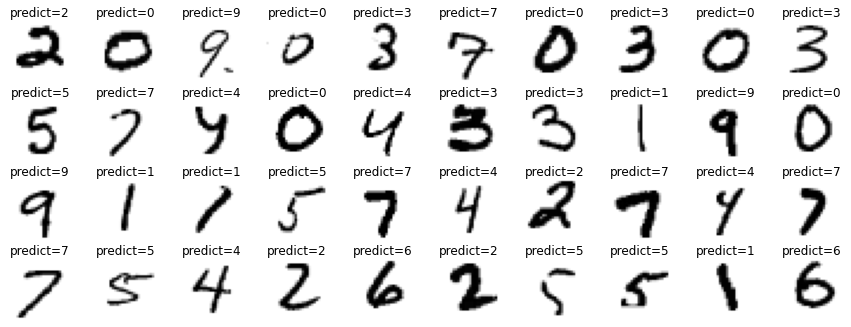

In [11]:
# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

### Credits

This following great NBs have been great reference for this NB

